# Mycrograd at work

<div style="text-align: justify">
In this notebook we run experiments to test the functioning of Mycrograd. 
We start by training a simple feed forward network on a randomly generated
dataset. We then train a decoder-only transformer to do additions of 2-digits numbers. Finally we compare our results with torch.
</div>

In [5]:
from my_engine import Tnsr # Our version of the torch.tensor class
import my_nn as nn # Our version of torch.nn
import my_optim as opt # Our version of torch.optim
import numpy as np
import time
from matplotlib import pyplot as plt
import random
import torch
import torch_layers # Handmade torch layers

## Feed forward

### Dataset

<div style="text-align: justify">
Generate a random data set of (X, y) where X is a Tnsr(batch_size, d_input) which
contains the input vectors and y is a Tnsr(batch_size,) which contains the classes. 
</div>

In [45]:
class dataloader_FF():

    def __init__(self, d_input, n_batches, batch_size, n_classes):
        self.d_input = d_input
        self.n_batches = n_batches
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.data = [
            (np.random.rand(batch_size, d_input),
              np.random.randint(n_classes, size=(batch_size, ))) 
              for _ in range(n_batches)
              ]

    def shuffle(self):
        random.shuffle(self.data)

    def __getitem__(self, index):
        return self.data[index]

### Training

In [46]:
class training_FF():

    def __init__(self, lr, criterion, d_input, n_batches, batch_size, op='SGD'):
        self.data = dataloader_FF(d_input, n_batches, batch_size, n_classes=2)
        self.model = nn.FeedForward(dims=[d_input, 40, 10, 2])
        if op == 'SGD':
            self.op = opt.SGD(params=self.model.parameters(), lr=lr)
        elif op == 'Adam':
            self.op = opt.Adam(params=self.model.parameters(), lr=lr)
        self.criterion = criterion
        self.n_batches = n_batches
        self.batch_size = batch_size
    
    def __call__(self, n_epochs):
        start_time = time.time()
        losses = []
        for epoch in range(n_epochs):
            self.data.shuffle()
            for X, y in self.data:
                self.op.zero_grad()
                output = self.model(Tnsr(X))
                loss = self.criterion(output, Tnsr(y))
                losses.append(loss.data)
                loss.backward()
                self.op.step()

        end_time = time.time()
        print(f'Duration of training: {end_time - start_time} seconds')

        fig = plt.figure(figsize=(5, 2))
        axes = fig.add_axes([0.1, 0.1, 1, 1])
        axes.set_ylim(0, max(losses))
        axes.set_ylabel('loss')
        axes.set_xlabel('epochs')
        axes.plot(list(range(len(losses))), losses)

Duration of training: 2.6753311157226562 seconds


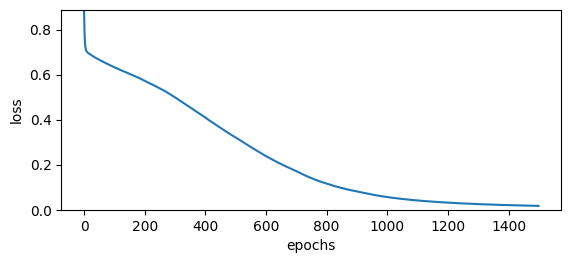

In [47]:
# SGD
training_FF(
    lr=1e-02, 
    criterion=nn.cross_entropy(), 
    d_input=100,
    n_batches=1, 
    batch_size=50,
    op='SGD'
    )(n_epochs=1500)

Duration of training: 3.119379997253418 seconds


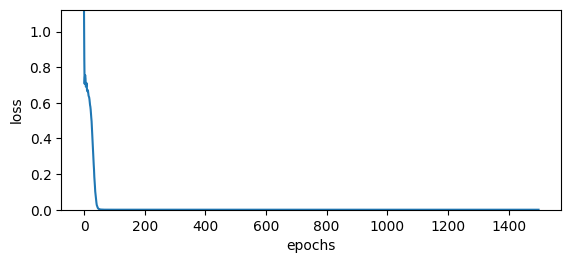

In [48]:
# Adam
training_FF(
    lr=1e-02, 
    criterion=nn.cross_entropy(), 
    d_input=100,
    n_batches=1, 
    batch_size=50,
    op='Adam'
    )(n_epochs=1500)

## Transformer

<div style="text-align: justify">
We construct a dataset for addition of 2-digits numbers.
The smallest number is (0 + 0 =) 0 and the largest one is
(99 + 99) = 198. The largest one has 3 digits which
means that the dataset must be sentences X of the type
X = {* * + * *  = reverse(* * *) stop}. The vocabulary contains therefore
13 elements: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, +, =, stop}. The reason
we added a reverse is that when the transformer is generating
the result, it is easier to compute first the units, then the tens,
the hundreds.
</div>

### Dataset

In [3]:
class dataloader():

    def __init__(self, batch_size, n_max):
        self.data_size = n_max ** 2
        self.batch_size = batch_size
        self.vocab_size = 13
        assert self.data_size % self.batch_size == 0, \
                    'data_size is not multiple of batch_size'
        # Take a list of the type [*, *, +, *, *, =, *, *, *, stop]
        # where the l.h.s corresponds to k and l written with 2 digits and
        # where the r.h.s is the reversed result written with 3 digits.
        # Apply the tokenizer 'to_numbers', which turns it into a list 
        # of numbers between 0 and 12. Then make it an array of shape=(1, 10)
        # where 10 is the length of a training sequence.
        self.data = [np.expand_dims(
            np.array(
            list(
            map(lambda x:self.to_numbers(x),
              list(f'{k:02d}') + ['+'] + list(f'{l:02d}') \
              + ['='] + list(f'{(k + l):03d}')[::-1] + ['stop']
            )
            )
            ), axis=0)
              for k in range(n_max)
                for l in range(n_max)
                ]
        # Shuffle the dataset
        random.shuffle(self.data)
        # We batch the dataset into arrays of shape=(batch_size, 10)
        self.data_batched = [
            np.concatenate(
            self.data[k * self.batch_size : (k + 1) * self.batch_size]
              ,
              axis=0)
              for k in range(self.data_size // self.batch_size)
              ]
        self.data_batched_size = len(self.data_batched)

    def reverse_num(self, num):
        number_str = str(num)
        reversed_str = number_str[::-1]
        reversed_num = int(reversed_str)
        return reversed_num
        
    def to_numbers(self, x):
        if x == '+': return 10
        elif x == '=': return 11
        elif x == 'stop': return 12
        else: return int(x)

    def to_string(self, x):
        if x == 10: return '+'
        elif x == 11: return '='
        elif x == 12: return 'stop'
        else: return str(x)    

    def __getitem__(self, index):
        X = self.data_batched[index][:, : -1]
        y = self.data_batched[index][:, 1 :]
        return X, y

### Training

Definition of the network: decoding-only transformer with 
two layers of masked attention. Our goal is to construct a 2-digits addition module with the transformer, so we overfit the dataset which contains all the additions of interest. In principle one could select a smaller training set and count on the generalization capabilities of the network, but here we just want to make sure the transformer and its handmade backpropagation work.

/Users/owner/Library/CloudStorage/GoogleDrive-marteau.charles.75@gmail.com/My Drive/Colab Notebooks/Deep Learning/Algorithms/GIT/Mycrograd/my_engine.py:204: RuntimeWarning: invalid value encountered in log
  output.grad * np.log(self.data) * (self.data ** other.data)


epoch 0: loss = 1.975479590912458
epoch 50: loss = 1.2870954738070348
epoch 100: loss = 1.2736867159415255
epoch 150: loss = 1.0863882834853145
epoch 200: loss = 0.9863581258930831
epoch 250: loss = 0.8142977309981764
epoch 300: loss = 0.7879128605769828
epoch 350: loss = 0.7785611924448439
epoch 400: loss = 0.9029266468487516
epoch 450: loss = 0.772454424723807
Training done! Duration: 2060.5890171527863s


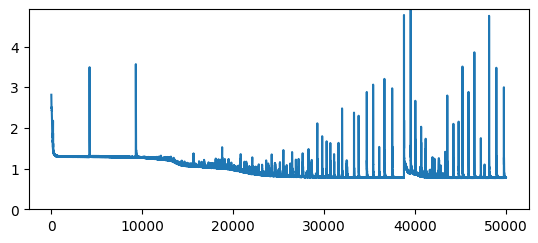

In [14]:
seed = np.random.seed(12)

# n_max - 1 is the largest number we can add.
# The dataset contains therefore 10^4 elements since
# there are 100*100 = 10^4 additions one can make.
data = dataloader(batch_size=100, n_max=100)

Tr = nn.Transformer(
    N=10000, n_heads=2, d_model=10, n_blocks=2, vocab_size=13
    )

op = opt.Adam(Tr.parameters(), lr=1e-3)
criterion = nn.cross_entropy()

start_time = time.time()
n_epochs = 500

losses = []

for epoch in range(n_epochs):
    for X, y in data:
        op.zero_grad()
        output = Tr(Tnsr(X))
        loss = criterion(output, Tnsr(y))
        losses.append(loss.data)
        loss.backward()
        op.step()
    if epoch % 50 == 0: print(f'epoch {epoch}: loss = {loss.data}')
    if loss.data <= 0.77: 
        # Specify the file name for the saved weights
        save_filename = "Transformer_weights"
        # Save the model weights
        np.savez(save_filename, *[Tr.parameters()[k].data for k in range(len(Tr.parameters()))])
        print('Saved!')
        break
   
end_time = time.time()
print(f'Training done! Duration: {end_time - start_time}s')

fig = plt.figure(figsize=(5, 2))
ax = fig.add_axes([0.1, 0.1, 1, 1])
ax.set_ylim(0, max(losses))
ax.plot(list(range(len(losses))), losses)

<div style="text-align: justify">
The loss doesn't go to zero. This is because the attention is masked.
In order to predict the result of the addition, the transformer can
use the first 5 tokens (* * + * *), but, before that, there is no way
for it to predict the next token since there is no correlation between 
tokens 1 , 2, 3 and 4. It can therefore predict the + and = signs but 
not the number added. The noise in the loss comes from this randomness
of the first part of the output sequence.
</div>

We can test this hyptothesis by looking at the transformer's prediction on the training set.

### Results

We start by saving the weights of our model

In [16]:
# Specify the file name for the saved weights
save_filename = "Transformer_weights"

# Save the model weights
np.savez(save_filename, *[Tr.parameters()[k].data for k in range(len(Tr.parameters()))])

And load the weights in a freshly prepared transformer

In [12]:
# We define a new Transformer with fresh weights
Tr_fresh = nn.Transformer(
    N=10000, n_heads=2, d_model=10, n_blocks=2, vocab_size=13
    )
# Load the saved list of weights from the file
loaded_data = np.load('Transformer_weights.npz')

for k, param in enumerate(Tr_fresh.parameters()):
    param.data = loaded_data[f'arr_{k}']

We define a function that prints a random input vs output

In [13]:
def random_sample(model, data):
    data_size = data.data_size
    batch_size = data.batch_size
    batch = random.randint(0, data_size // batch_size - 1)
    batch_element = random.randint(0, batch_size - 1)
    input = data[batch][0].take(indices=(batch_element,), axis=0)
    output = model(Tnsr(input)).data
    output = output.argmax(axis=-1)
    input_seq = ' '.join(list(map(lambda x:data.to_string(int(x)), list(input.squeeze()))))
    output_seq = ' '.join(list(map(lambda x:data.to_string(x), list(output.squeeze()))))
    input_seq = input_seq[0 : 12] + input_seq[ : 11 : -1]
    output_seq = output_seq[0: 10] + output_seq[14 : 9: -1] + output_seq[15 :]
    print('input: ' + input_seq + '\noutput:  ' + output_seq)

In [14]:
random_sample(Tr_fresh, data)

input: 7 5 + 9 4 = 1 6 9
output:  4 + 4 0 = 1 6 9 stop


<div style="text-align: justify">
It is now clear that the predicted r.h.s. of the equation is right
while the l.h.s. is completely wrong. This is because of the masked
attention: after seeing the whole l.h.s. the network can predict the
result, but there is no way to predict what comes before.
</div>

### Inference

We can now build an addition module using our transformer. We feed a prompt of the type { * * + * * = } and we let the transformer predict the next 4 tokens which should be the result of the addition (reversed) followed by a stop token.

In [19]:
class addition():

    def __init__(self, model, data):
        self.model = model
        self.data = data
    
    def __call__(self, int1, int2):
        input_string = f'{int1:02d}' + '+' + f'{int2:02d}' + '='
        list_tokens = list(map(lambda x:self.data.to_numbers(x), input_string))
        result = []
        for _ in range(4):
            input = Tnsr(np.array(list_tokens)) 
            output = self.model(input).data
            next_token = output[-1].argmax(axis=-1)
            list_tokens.append(next_token)
            result.append(str(next_token))
        raw_output = list(map(lambda x: data.to_string(x), list(map(lambda x:int(x), result))))
        result = result[0:2] 
        result.reverse() 
        print(f'raw input:  {list(input_string)}\nraw output: {raw_output}') 
        return int(''.join(result[0:3]))

In [111]:
# Test a few examples
int1 = random.randint(0, 99)
int2 = random.randint(0, 99)
sum = addition(Tr_fresh, data)(int1, int2)
print(f'{int1} + {int2} = {sum}')

raw input:  ['6', '4', '+', '9', '6', '=']
raw output: ['0', '6', '1', 'stop']
64 + 96 = 60


In [42]:
# Full scanning: look for the errors among the 100 * 100 = 10^4 possible additions
count = 0
for int1 in range(100):
    for int2 in range(100):
        if addition(Tr_fresh, data)(int1, int2) != int1 + int2: 
            print(f'Error! {int1} + {int2} = {addition(Tr_fresh, data)(int1, int2)}')
            count += 1
print(count)

Error! 0 + 0 = 10
Error! 0 + 90 = 81
Error! 1 + 0 = 11
Error! 1 + 9 = 0
Error! 2 + 0 = 12
Error! 5 + 4 = 19
Error! 6 + 3 = 19
Error! 7 + 2 = 19
Error! 8 + 1 = 19
Error! 8 + 9 = 7
Error! 9 + 79 = 188
Error! 9 + 89 = 198
Error! 98 + 91 = 179
Error! 99 + 17 = 106
Error! 99 + 18 = 107
Error! 99 + 19 = 108
16


Only 16 error over the 10^4 additions in the dataset! 

# Comparison with torch

<div style="text-align: justify">
We now reproduce the exact same experiments using only torch
functionalities. By construction the results are roughly the same,
the only main difference being the time required for execution,
which is due to a better optimization of all the components in pytorch.
</div>

## Feed forward - Torch

### Dataset

We use the same dataset as in the Sec. Feed forward.

### Training

In [58]:
class training_FF_torch():

    def __init__(self, lr, criterion, d_input, n_batches, batch_size, op='SGD'):
        self.data = dataloader_FF(d_input, n_batches, batch_size, n_classes=2)
        L1 = torch.nn.Linear(d_input, 40)
        L2 = torch.nn.Linear(40, 10)
        L3 = torch.nn.Linear(10, 2)
        self.model = torch.nn.Sequential(L1, torch.nn.ReLU(), L2, torch.nn.ReLU(), L3)
        if op == 'SGD':
            self.op = torch.optim.SGD(params=self.model.parameters(), lr=lr)
        elif op == 'Adam':
             self.op = torch.optim.Adam(params=self.model.parameters(), lr=lr)
        self.criterion = criterion
        self.n_batches = n_batches
        self.batch_size = batch_size
    
    def __call__(self, n_epochs):
        start_time = time.time()
        losses = []
        for epoch in range(n_epochs):
            self.data.shuffle()
            for X, y in self.data:
                self.op.zero_grad()
                output = self.model(torch.tensor(X, dtype=torch.float32))
                loss = self.criterion(output, torch.tensor(y))
                losses.append(loss.data)
                loss.backward()
                self.op.step()

        end_time = time.time()
        print(f'Duration of training: {end_time - start_time} seconds')

        fig = plt.figure(figsize=(5, 2))
        axes = fig.add_axes([0.1, 0.1, 1, 1])
        axes.set_ylim(0, max(losses))
        axes.set_ylabel('loss')
        axes.set_xlabel('epochs')
        axes.plot(list(range(len(losses))), losses)

Duration of training: 0.9364678859710693 seconds


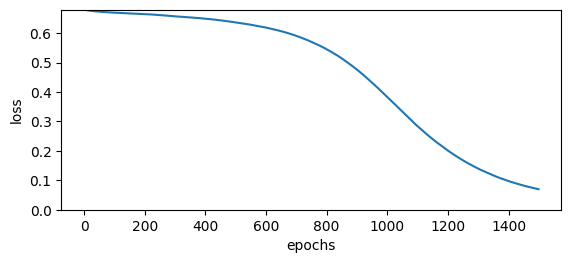

In [60]:
# SGD
training_FF_torch(
    lr=1e-02, 
    criterion=torch.nn.CrossEntropyLoss(), 
    d_input=100,
    n_batches=1, 
    batch_size=50,
    op='SGD'
    )(n_epochs=1500)

Duration of training: 1.6544129848480225 seconds


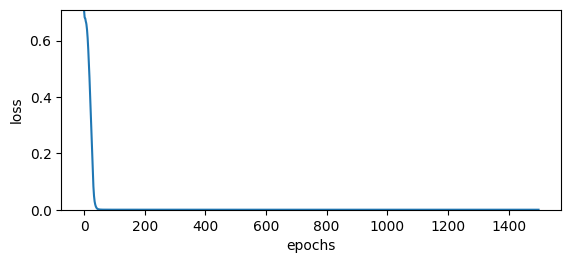

In [61]:
# Adam
training_FF_torch(
    lr=1e-02, 
    criterion=torch.nn.CrossEntropyLoss(), 
    d_input=100,
    n_batches=1, 
    batch_size=50,
    op='Adam'
    )(n_epochs=1500)

## Transformer - Torch

### Dataset

We use the same dataset as in Sec. Transformer.

### Training

epoch 0: loss = 2.3049674034118652
epoch 50: loss = 1.277860164642334
epoch 100: loss = 1.2248002290725708
epoch 150: loss = 1.037904977798462
epoch 200: loss = 1.0038719177246094
epoch 250: loss = 0.7735539674758911
epoch 300: loss = 0.7707937955856323
epoch 350: loss = 0.7727733850479126
epoch 400: loss = 0.7705711722373962
epoch 450: loss = 0.7713819742202759
Training done! Duration: 797.8054478168488s


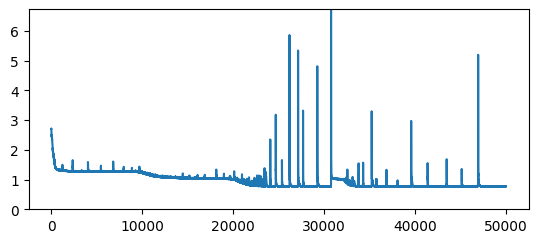

In [64]:
seed = np.random.seed(12)

# n_max - 1 is the largest number we can add.
# The dataset contains therefore 10000 elements since
# there are 100*100 = 10000 additions one can make.
data = dataloader(batch_size=100, n_max=100)

Tr = torch_layers.Transformer(
    N=10000, num_heads=2, d_model=10, n_blocks=2, vocab_size=13, dropout=0
    )

op = torch.optim.Adam(Tr.parameters(), lr=1e-03)
criterion = torch.nn.CrossEntropyLoss()

start_time = time.time()
n_epochs = 500

losses = []

for epoch in range(n_epochs):
    for X, y in data:
        op.zero_grad()
        output = Tr(torch.tensor(X))
        loss = criterion(output.reshape(-1, output.shape[-1]), torch.tensor(y).reshape(-1))
        losses.append(loss.data)
        loss.backward()
        op.step()
    if epoch % 50 == 0: print(f'epoch {epoch}: loss = {loss.data}')
    
   
end_time = time.time()
print(f'Training done! Duration: {end_time - start_time}s')

fig = plt.figure(figsize=(5, 2))
ax = fig.add_axes([0.1, 0.1, 1, 1])
ax.set_ylim(0, max(losses))
ax.plot(list(range(len(losses))), losses)